Никита № 210134120970:k

In [561]:
import matplotlib.pyplot as plt
import numpy as np

In [562]:
base_h = 5.795 # см
_maybe_correct_base_h = 5.755 # см

delta_h = 7.53 - base_h # разность высот в u-образной штуке
T = 22.64 + 273.15      # К
sigma_T = .5            # K
sigma_h = .005 * 0.01   # m

RHO_HG = 13600
g      = 9.81
CVT_K  = 273.15
R      = 8.31

In [563]:
def LeastSquares(x_arr, y_arr): # returns [k, b, sigma_k, sigma b]
    v = x_arr
    u = y_arr

    N = len(v)

    mu = np.mean(u) # средее
    mv = np.mean(v)
    mv2 = np.mean([v_i**2 for v_i in v]) # средний квадрат
    mu2 = np.mean([u_i**2 for u_i in u])
    muv = np.mean ([u[i] * v[i] for i in range(len(u))]) # среднее от произведения
    k = (muv - mu * mv) / (mv2 - mv**2)
    b = mu - k * mv

    sigma_k = np.sqrt(1/(N-2) * ( (mu2 - mu**2)/(mv2 - mv**2) - k**2 ) )
    sigma_b = sigma_k * np.sqrt(mv2)

    return (k, b, sigma_k, sigma_b)

In [564]:
def DrawGraphLogTP (fmt, x, y, xerr, yerr, k, b):
    plt.xlabel("$\\frac{1}{T}, ~K^{-1}$")
    plt.ylabel("$ln(P)$")

    plt.grid(True, linestyle = '--')

    plt.tick_params(axis='x', which='major', labelsize=7)

    plt.errorbar(x, y, xerr=xerr, yerr=yerr, ls = "None", fmt=fmt)

    x = np.array ([x[0], x[-1]])
    plt.plot (x, k * x + b, "-", linewidth = 1)

def get_latex_table (array, n_round, caption=None, label=None):
    # Определяем количество столбцов
    num_cols = len(array[0])

    # Создаем шапку таблицы
    latex_table = "\\begin{table}[H]\n"
    latex_table += "\\centering\n"
    if caption != None:
        latex_table += "\\caption{"
        latex_table += caption
        latex_table += "}\n"

    if label != None:
        latex_table += "\\label{"
        latex_table += label
        latex_table += "}\n"

    latex_table += "\\begin{tabular}{|"

    for i in range(num_cols):
        latex_table += "c|"
    latex_table += "}\n"

    latex_table += "\\hline\n"

    # заголовок
    latex_table += " & ".join(str(elem) for elem in array[0])
    latex_table += " \\\\ \\hline\n"

    # Добавляем строки массива
    for row in np.transpose(array[1:]):
        latex_table += " & ".join(str(round(elem, n_round)) for elem in row)
        latex_table += " \\\\ \\hline\n"

    latex_table += "\\end{tabular}\n"
    latex_table += "\\end{table}"

    print (latex_table)
    return latex_table

def GetCalcReport (res_name, res_measure, val, sigma, n_round):
    print ("$" + res_name + " = (" + str(round(val, n_round)) + "~\\pm " + str(round(sigma, n_round)) + ") ~\\text{" + res_measure + "} ~(\\varepsilon ~\\approx " + str(round(sigma / val * 100, 2)) + " \\%) " + "$")

In [565]:
class Experiment:
    def __init__(self, Ts, hs, bases_h) -> None:

        self.Ts                 = [CVT_K + T for T in Ts]
        self.sigmas_T           = [sigma_T] * len (Ts)
        self._1_T               = [1 / T for T in self.Ts]
        self.sigmas_1_T         = [sigma_T / T**2 for T in self.Ts]

        self.dh                 = [(h - base_h) * 0.01 for h, base_h in zip(hs, bases_h)]

        self.deltas_p           = [RHO_HG * g * dh for dh in self.dh]
        self.sigmas_delta_p     = [RHO_HG * g * sigma_h] * len (Ts)
        self.ln_deltas_p        = [np.log(p) for p in self.deltas_p]
        self.sigmas_ln_delta_p  = [sigma_p / p for p, sigma_p in zip(self.deltas_p, self.sigmas_delta_p)]


        self.dP_dT, self.b_PT, self.sigma_dP_dT, self.berr = LeastSquares (self.Ts, self.deltas_p)

        self.dlnP_d1_T, self.blnP_1_T, self.sigma_logdPT, self.berr = LeastSquares (self._1_T, self.ln_deltas_p)

        self.L = -R * self.dlnP_d1_T
        self.sigma_L = np.abs (- R * self.sigma_logdPT)
        self.eps_L   = np.abs (self.sigma_logdPT / self.L * 100)

        print ("data received")

    def DrawTP (self, title):
        plt.figure()
        plt.title(title)
        plt.ylabel("$P, Па$")
        plt.xlabel("$T, К$")

        plt.grid(True, linestyle = '--')

        plt.errorbar(self.Ts, self.deltas_p, xerr=self.sigmas_T, yerr=self.sigmas_delta_p, ls = "None", fmt=".k")

        k = self.dP_dT
        b = self.b_PT
        x = np.array ([self.Ts[0], self.Ts[-1]])
        plt.plot (x, k * x + b, "-", linewidth = 1)

        plt.show()

    def DrawLogTP (self, title):
        plt.figure()
        plt.title(title)

        DrawGraphLogTP (".k", self._1_T, self.ln_deltas_p, self.sigmas_1_T, self.sigmas_ln_delta_p, self.dlnP_d1_T, self.blnP_1_T)

        plt.show()

In [566]:
T       = [22.64, 23.36, 24.33, 25.29, 26.17, 27.12, 28.07, 29.10, 30.05, 31.15, 33.03, 34.08, 35.15, 36.13, 37.05, 38.10, 39.10, 40]
h       = [7.53,  7.515, 7.575, 7.67,  7.71,  7.805, 7.865, 7.970, 8.07,  8.145, 8.320, 8.445, 8.570, 8.710, 8.770, 8.965, 9.040, 9.24]
bases_h = [6.02,  5.795, 5.795, 5.755, 5.705, 5.61,  5.555, 5.455, 5.395, 5.300, 5.175, 4.995, 4.905, 4.865, 4.700, 4.600, 4.465, 4.35]
dh_up   = [h - base_h for h, base_h in zip(h, bases_h)]
get_latex_table ([['т', 'h', 'bh'],T, h, bases_h], 2)

\begin{table}[H]
\centering
\begin{tabular}{|c|c|c|}
\hline
т & h & bh \\ \hline
22.64 & 7.53 & 6.02 \\ \hline
23.36 & 7.52 & 5.8 \\ \hline
24.33 & 7.58 & 5.8 \\ \hline
25.29 & 7.67 & 5.76 \\ \hline
26.17 & 7.71 & 5.7 \\ \hline
27.12 & 7.8 & 5.61 \\ \hline
28.07 & 7.86 & 5.56 \\ \hline
29.1 & 7.97 & 5.46 \\ \hline
30.05 & 8.07 & 5.4 \\ \hline
31.15 & 8.14 & 5.3 \\ \hline
33.03 & 8.32 & 5.18 \\ \hline
34.08 & 8.44 & 5.0 \\ \hline
35.15 & 8.57 & 4.9 \\ \hline
36.13 & 8.71 & 4.86 \\ \hline
37.05 & 8.77 & 4.7 \\ \hline
38.1 & 8.96 & 4.6 \\ \hline
39.1 & 9.04 & 4.46 \\ \hline
40.0 & 9.24 & 4.35 \\ \hline
\end{tabular}
\end{table}


'\\begin{table}[H]\n\\centering\n\\begin{tabular}{|c|c|c|}\n\\hline\nт & h & bh \\\\ \\hline\n22.64 & 7.53 & 6.02 \\\\ \\hline\n23.36 & 7.52 & 5.8 \\\\ \\hline\n24.33 & 7.58 & 5.8 \\\\ \\hline\n25.29 & 7.67 & 5.76 \\\\ \\hline\n26.17 & 7.71 & 5.7 \\\\ \\hline\n27.12 & 7.8 & 5.61 \\\\ \\hline\n28.07 & 7.86 & 5.56 \\\\ \\hline\n29.1 & 7.97 & 5.46 \\\\ \\hline\n30.05 & 8.07 & 5.4 \\\\ \\hline\n31.15 & 8.14 & 5.3 \\\\ \\hline\n33.03 & 8.32 & 5.18 \\\\ \\hline\n34.08 & 8.44 & 5.0 \\\\ \\hline\n35.15 & 8.57 & 4.9 \\\\ \\hline\n36.13 & 8.71 & 4.86 \\\\ \\hline\n37.05 & 8.77 & 4.7 \\\\ \\hline\n38.1 & 8.96 & 4.6 \\\\ \\hline\n39.1 & 9.04 & 4.46 \\\\ \\hline\n40.0 & 9.24 & 4.35 \\\\ \\hline\n\\end{tabular}\n\\end{table}'

In [567]:
T       = [40,   39,    38.02, 37.15, 35.15, 34.15, 33.06, 32.05, 31.06, 30.20, 29.05, 28.07, 27.07, 26.12, 25.18, 24.27, 23.32]
h       = [9.24, 9.195, 9.095, 8.93,  8.772, 8.595, 8.445, 8.345, 8.27,  8.17,  8.090, 7.97,  7.91,  7.835, 7.735, 7.64,  7.560]
bases_h = [4.35, 4.360, 4.430, 4.59,  4.775, 4.88,  4.995, 5.05,  5.175, 5.27,  5.355, 5.45,  5.495, 5.565, 5.67,  5.73,  5.845]
dh_down = [h - base_h for h, base_h in zip(h, bases_h)]
get_latex_table ([['т', 'h', 'bh'],T, h, bases_h], 2)

\begin{table}[H]
\centering
\begin{tabular}{|c|c|c|}
\hline
т & h & bh \\ \hline
40.0 & 9.24 & 4.35 \\ \hline
39.0 & 9.2 & 4.36 \\ \hline
38.02 & 9.1 & 4.43 \\ \hline
37.15 & 8.93 & 4.59 \\ \hline
35.15 & 8.77 & 4.78 \\ \hline
34.15 & 8.6 & 4.88 \\ \hline
33.06 & 8.44 & 5.0 \\ \hline
32.05 & 8.35 & 5.05 \\ \hline
31.06 & 8.27 & 5.18 \\ \hline
30.2 & 8.17 & 5.27 \\ \hline
29.05 & 8.09 & 5.36 \\ \hline
28.07 & 7.97 & 5.45 \\ \hline
27.07 & 7.91 & 5.5 \\ \hline
26.12 & 7.84 & 5.56 \\ \hline
25.18 & 7.74 & 5.67 \\ \hline
24.27 & 7.64 & 5.73 \\ \hline
23.32 & 7.56 & 5.84 \\ \hline
\end{tabular}
\end{table}


'\\begin{table}[H]\n\\centering\n\\begin{tabular}{|c|c|c|}\n\\hline\nт & h & bh \\\\ \\hline\n40.0 & 9.24 & 4.35 \\\\ \\hline\n39.0 & 9.2 & 4.36 \\\\ \\hline\n38.02 & 9.1 & 4.43 \\\\ \\hline\n37.15 & 8.93 & 4.59 \\\\ \\hline\n35.15 & 8.77 & 4.78 \\\\ \\hline\n34.15 & 8.6 & 4.88 \\\\ \\hline\n33.06 & 8.44 & 5.0 \\\\ \\hline\n32.05 & 8.35 & 5.05 \\\\ \\hline\n31.06 & 8.27 & 5.18 \\\\ \\hline\n30.2 & 8.17 & 5.27 \\\\ \\hline\n29.05 & 8.09 & 5.36 \\\\ \\hline\n28.07 & 7.97 & 5.45 \\\\ \\hline\n27.07 & 7.91 & 5.5 \\\\ \\hline\n26.12 & 7.84 & 5.56 \\\\ \\hline\n25.18 & 7.74 & 5.67 \\\\ \\hline\n24.27 & 7.64 & 5.73 \\\\ \\hline\n23.32 & 7.56 & 5.84 \\\\ \\hline\n\\end{tabular}\n\\end{table}'

In [568]:
ExpTempGrow = Experiment ([22.64, 23.36, 24.33, 25.29, 26.17, 27.12, 28.07, 29.10, 30.05, 31.15, 33.03, 34.08, 35.15, 36.13, 37.05, 38.10, 39.10, 40  ],
                          [7.53,  7.515, 7.575, 7.67,  7.71,  7.805, 7.865, 7.970, 8.07,  8.145, 8.320, 8.445, 8.570, 8.710, 8.770, 8.965, 9.040, 9.24],
                          [6.02,  5.795, 5.795, 5.755, 5.705, 5.61,  5.555, 5.455, 5.395, 5.300, 5.175, 4.995, 4.905, 4.865, 4.700, 4.600, 4.465, 4.35])

data received


In [569]:
ExpTempDrop = Experiment ([40,   39,    38.02, 37.15, 35.15, 34.15, 33.06, 32.05, 31.06, 30.20, 29.05, 28.07, 27.07, 26.12, 25.18, 24.27, 23.32],
                          [9.24, 9.195, 9.095, 8.93,  8.772, 8.595, 8.445, 8.345, 8.27,  8.17,  8.090, 7.97,  7.91,  7.835, 7.735, 7.64,  7.560],
                          [4.35, 4.360, 4.430, 4.59,  4.775, 4.88,  4.995, 5.05,  5.175, 5.27,  5.355, 5.45,  5.495, 5.565, 5.67,  5.73,  5.845])

data received


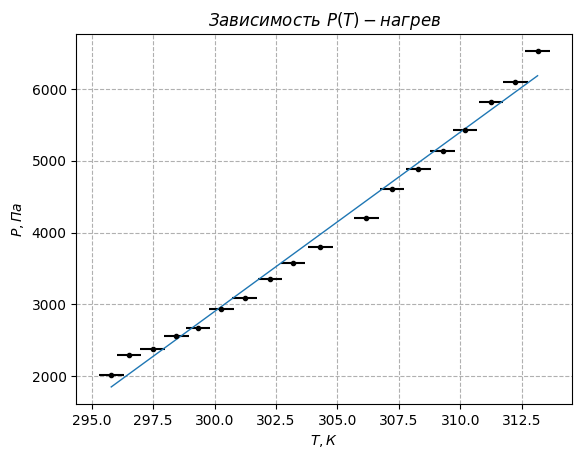

In [570]:
ExpTempGrow.DrawTP('$Зависимость ~P(T) - нагрев$')

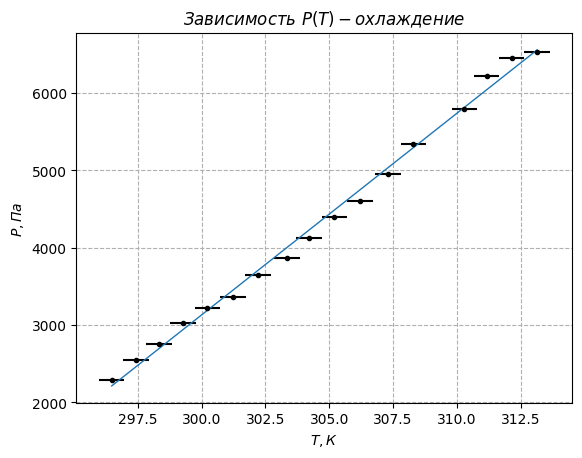

In [571]:
ExpTempDrop.DrawTP('$Зависимость ~P(T) - охлаждение$')

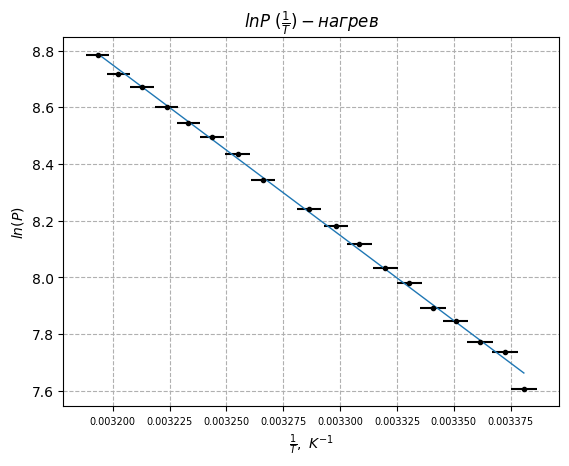

In [572]:
ExpTempGrow.DrawLogTP ("$lnP ~(\\frac{1}{T}) - нагрев$")

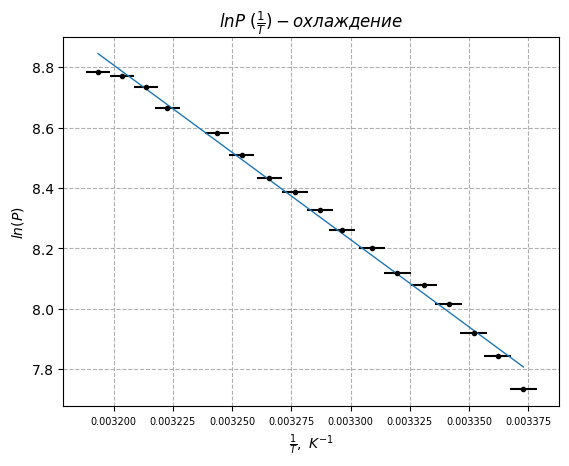

In [573]:
ExpTempDrop.DrawLogTP ("$lnP ~(\\frac{1}{T}) - охлаждение$")

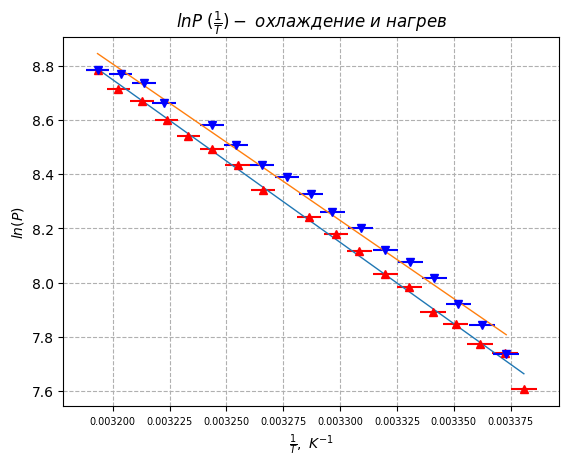

In [574]:
plt.title ("$lnP ~(\\frac{1}{T}) - ~охлаждение ~и ~нагрев$")
DrawGraphLogTP ("^r", ExpTempGrow._1_T, ExpTempGrow.ln_deltas_p, ExpTempGrow.sigmas_1_T, ExpTempGrow.sigmas_ln_delta_p, ExpTempGrow.dlnP_d1_T, ExpTempGrow.blnP_1_T)
DrawGraphLogTP ("vb", ExpTempDrop._1_T, ExpTempDrop.ln_deltas_p, ExpTempDrop.sigmas_1_T, ExpTempDrop.sigmas_ln_delta_p, ExpTempDrop.dlnP_d1_T, ExpTempDrop.blnP_1_T)
plt.show()

In [575]:
ExpTempGrow.L, ExpTempGrow.sigma_L, ExpTempGrow.eps_L

(49920.15078630192, 632.4952755088932, 0.15246858632666888)

In [576]:
ExpTempDrop.L, ExpTempDrop.sigma_L, ExpTempDrop.eps_L

(48016.392492633335, 1125.1902383576721, 0.281991101466238)

In [577]:
ExpTempGrow.dP_dT, ExpTempGrow.sigma_dP_dT, ExpTempGrow.sigma_dP_dT / ExpTempGrow.dP_dT * 100

(249.78585878702404, 6.983703173394943, 2.7958761185714227)

In [578]:
GetCalcReport ("dP/dT", "Па/К", ExpTempDrop.dP_dT, ExpTempDrop.sigma_dP_dT, 2)
GetCalcReport ("d(lnP)/d(1/T)", "1/моль", ExpTempDrop.dlnP_d1_T, ExpTempDrop.sigma_logdPT, 2)
GetCalcReport ("d(lnP)/d(1/T)", "1/моль", ExpTempGrow.dlnP_d1_T, ExpTempGrow.sigma_logdPT, 2)

$dP/dT = (260.47~\pm 4.86) ~\text{Па/К} ~(\varepsilon ~\approx 1.86 \%) $
$d(lnP)/d(1/T) = (-5778.15~\pm 135.4) ~\text{1/моль} ~(\varepsilon ~\approx -2.34 \%) $
$d(lnP)/d(1/T) = (-6007.24~\pm 76.11) ~\text{1/моль} ~(\varepsilon ~\approx -1.27 \%) $


In [581]:
GetCalcReport ("L", "Дж/К", ExpTempGrow.L, ExpTempGrow.sigma_L, 2)
GetCalcReport ("L", "Дж/К", ExpTempDrop.L, ExpTempDrop.sigma_L, 2)

GetCalcReport ("L", "Дж/К", np.mean([ExpTempDrop.L, ExpTempGrow.L]), np.sqrt(ExpTempDrop.sigma_L**2 + ExpTempGrow.sigma_L), 2)

$L = (49920.15~\pm 632.5) ~\text{Дж/К} ~(\varepsilon ~\approx 1.27 \%) $
$L = (48016.39~\pm 1125.19) ~\text{Дж/К} ~(\varepsilon ~\approx 2.34 \%) $
$L = (48968.27~\pm 1125.47) ~\text{Дж/К} ~(\varepsilon ~\approx 2.3 \%) $
